# 📊 Task 3: Correlation Analysis Between News Sentiment and Stock Movements

## 🎯 Business Objective

Nova Financial Solutions aims to enhance its predictive analytics capabilities by establishing statistical correlations between financial news sentiment and stock price movements. This analysis will enable data-driven investment strategies leveraging the relationship between news sentiment and stock performance.

## 📋 Task Overview

This notebook implements the complete Task 3 workflow:

1. **Data Profiling & Cleaning**: Comprehensive EDA on both news and stock datasets
2. **Date Alignment**: Normalize timestamps and align news with trading days
3. **Sentiment Analysis**: Quantify headline sentiment using NLTK VADER and TextBlob
4. **Stock Returns Calculation**: Compute daily percentage changes in stock prices
5. **Correlation Analysis**: Calculate Pearson correlation between sentiment and returns
6. **Visualization Dashboard**: Create comprehensive visualizations of correlations

---

## 📚 References & Best Practices

- **Sentiment Analysis**: VADER (Valence Aware Dictionary and sEntiment Reasoner) - optimized for social media and financial text
- **Correlation Methods**: Pearson correlation coefficient for linear relationships
- **Data Alignment**: Market close time (16:00 EST/EDT) as critical cutoff for news impact
- **Repository Best Practices**: Modular code structure, comprehensive documentation, version control


## 🔧 Setup and Dependencies


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import sys

# Sentiment Analysis Libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Initialize NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

print("✅ All dependencies loaded successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All dependencies loaded successfully!
📅 Analysis Date: 2025-11-24 22:16:52


## 📥 Data Loading


In [31]:
# Import the task3 script functions
import sys
import os
from pathlib import Path
import importlib.util

# Get current working directory and determine project root
current_dir = Path(os.getcwd())

# If we're in notebooks/, project root is one level up
# Otherwise, walk up to find project root
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    # Walk up to find project root (has both 'scripts' and 'notebooks' directories)
    project_root = current_dir
    while project_root != project_root.parent:
        if (project_root / 'scripts').exists() and (project_root / 'notebooks').exists():
            break
        project_root = project_root.parent

# Add project root to Python path for package imports (better IDE support)
project_root_path = str(project_root.resolve())
if project_root_path not in sys.path:
    sys.path.insert(0, project_root_path)

# Import using importlib for better IDE compatibility
scripts_dir = project_root / 'scripts'
module_path = scripts_dir / 'task3_correlation_analysis.py'

if module_path.exists():
    spec = importlib.util.spec_from_file_location("task3_correlation_analysis", module_path)
    task3_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(task3_module)
    
    # Extract functions
    load_news_data = task3_module.load_news_data
    load_stock_data = task3_module.load_stock_data
    clean_news_data = task3_module.clean_news_data
    clean_stock_data = task3_module.clean_stock_data
    normalize_dates = task3_module.normalize_dates
    calculate_sentiment = task3_module.calculate_sentiment
    calculate_stock_returns = task3_module.calculate_stock_returns
    aggregate_sentiment = task3_module.aggregate_sentiment
    save_results = task3_module.save_results
    
    print(f"✅ Successfully imported from: {module_path}")
else:
    raise FileNotFoundError(f"Module not found at {module_path}")

# Load data using paths relative to project root
news_file = project_root / 'data' / 'raw' / 'raw_analyst_ratings.csv'
stock_dir = project_root / 'data' / 'raw' / 'stock_prices'

news_df = load_news_data(str(news_file))
stock_prices_df = load_stock_data(str(stock_dir))


✅ Successfully imported from: d:\Senait Doc\KAIM 8 Doc\Nova_Financial_Analysis\scripts\task3_correlation_analysis.py
📰 Loading Financial News Dataset...
✅ News data loaded: 5,064 records

📈 Loading Stock Price Data...
  ✅ AAPL: 3,774 records
  ✅ AMZN: 3,774 records
  ✅ GOOG: 3,774 records
  ✅ META: 2,923 records
  ✅ MSFT: 3,774 records
  ✅ NVDA: 3,774 records

✅ Total stock price records: 21,793


## 🧹 Data Cleaning and Preparation


In [32]:
# Clean data
news_df = clean_news_data(news_df)
stock_prices_df = clean_stock_data(stock_prices_df)

# Display cleaned data info
print(f"\n📊 News Data Shape: {news_df.shape}")
print(f"📊 Stock Data Shape: {stock_prices_df.shape}")
print(f"\n📈 News Records per Stock:")
print(news_df['stock'].value_counts())



🧹 Cleaning News Data...
  Removed 0 rows with missing data
✅ Cleaned news data: 5,064 records

🧹 Cleaning Stock Price Data...
  Removed 0 rows with missing data
  Removed 0 duplicate entries
✅ Cleaned stock price data: 21,793 records

📊 News Data Shape: (5064, 6)
📊 Stock Data Shape: (21793, 7)

📈 News Records per Stock:
stock
NVDA    3146
GOOG    1199
AAPL     441
AMZN     278
Name: count, dtype: int64


## 📅 Date Alignment


In [33]:
# Normalize dates
news_df = normalize_dates(news_df)
# Ensure stock prices Date is timezone-naive and normalized
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.tz_localize(None).dt.normalize()

print(f"\n📅 News Date Range: {news_df['aligned_date'].min()} to {news_df['aligned_date'].max()}")
print(f"📅 Stock Date Range: {stock_prices_df['Date'].min()} to {stock_prices_df['Date'].max()}")
print(f"\n📊 Date column types:")
print(f"  News aligned_date: {news_df['aligned_date'].dtype}")
print(f"  Stock Date: {stock_prices_df['Date'].dtype}")



📅 Normalizing Dates for News Data...
  Removed 5024 rows with invalid dates
✅ Date normalization complete: 40 records

📅 News Date Range: 2020-05-31 00:00:00-04:00 to 2020-06-10 00:00:00-04:00
📅 Stock Date Range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00

📊 Date column types:
  News aligned_date: datetime64[ns, America/New_York]
  Stock Date: datetime64[ns]


## 💭 Sentiment Analysis


In [34]:
# Calculate sentiment scores
news_df = calculate_sentiment(news_df)

# Display sentiment statistics
print("\n📊 Sentiment Statistics:")
print(news_df[['vader_compound', 'vader_pos', 'vader_neg', 'textblob_polarity']].describe())



💭 Performing Sentiment Analysis...
  Calculating VADER scores...
  Calculating TextBlob scores...
✅ Sentiment analysis complete

📊 Sentiment Statistics:
       vader_compound  vader_pos  vader_neg  textblob_polarity
count       40.000000  40.000000  40.000000          40.000000
mean         0.196575   0.129150   0.031325           0.087364
std          0.373064   0.136662   0.101078           0.171427
min         -0.840200   0.000000   0.000000          -0.208333
25%          0.000000   0.000000   0.000000           0.000000
50%          0.114750   0.118000   0.000000           0.000000
75%          0.518525   0.222000   0.000000           0.127083
max          0.729600   0.396000   0.500000           0.500000


## 📈 Stock Returns Calculation


In [35]:
# Calculate daily returns
stock_prices_df = calculate_stock_returns(stock_prices_df)

# Display returns statistics
print("\n📊 Daily Returns Statistics by Ticker:")
print(stock_prices_df.groupby('Ticker')['daily_return'].describe())



📈 Calculating Daily Stock Returns...
✅ Daily returns calculated: 21,787 records

📊 Daily Returns Statistics by Ticker:
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    3773.0  0.001289  0.018010 -0.128647 -0.007547  0.001062  0.010770   
AMZN    3773.0  0.001303  0.021829 -0.140494 -0.009258  0.000916  0.012208   
GOOG    3773.0  0.000910  0.017334 -0.111008 -0.006929  0.000724  0.009278   
META    2922.0  0.001082  0.025280 -0.263901 -0.010045  0.000998  0.012825   
MSFT    3773.0  0.000996  0.016885 -0.147391 -0.007168  0.000716  0.009422   
NVDA    3773.0  0.001877  0.028917 -0.187558 -0.012537  0.001664  0.016090   

             max  
Ticker            
AAPL    0.119808  
AMZN    0.267951  
GOOG    0.160524  
META    0.296115  
MSFT    0.142169  
NVDA    0.298067  


## 📊 Sentiment Aggregation

Aggregate daily sentiment scores by stock ticker and date. This creates a summary dataset with average, maximum, and minimum sentiment scores per day for each stock.


In [36]:
# Verify required columns exist before aggregation
print("🔍 Checking required columns for aggregation...")
required_cols = ['stock', 'aligned_date', 'vader_compound', 'vader_pos', 'vader_neg', 'textblob_polarity']
missing_cols = [col for col in required_cols if col not in news_df.columns]

if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
    print(f"📋 Available columns: {list(news_df.columns)}")
    print("\n⚠️  Please ensure you have run:")
    print("   1. Date normalization (normalize_dates)")
    print("   2. Sentiment analysis (calculate_sentiment)")
    raise KeyError(f"Missing required columns: {missing_cols}")
else:
    print(f"✅ All required columns present: {required_cols}")

# Aggregate sentiment by date
sentiment_aggregated = aggregate_sentiment(news_df)

# Display aggregation results
if not sentiment_aggregated.empty:
    print(f"\n📊 Aggregated Sentiment Summary:")
    print(f"   Total daily records: {len(sentiment_aggregated):,}")
    print(f"   Date range: {sentiment_aggregated['aligned_date'].min()} to {sentiment_aggregated['aligned_date'].max()}")
    print(f"\n📊 Sentiment Statistics:")
    print(sentiment_aggregated[['avg_vader_compound', 'max_vader_compound', 'min_vader_compound', 
                                 'avg_vader_pos', 'avg_vader_neg', 'news_count']].describe())

    print(f"\n📊 Sample Aggregated Sentiment Data:")
    print(sentiment_aggregated.head(10))

    print(f"\n📊 Sentiment Records by Stock:")
    print(sentiment_aggregated['stock'].value_counts())
else:
    print("⚠️  No aggregated sentiment data generated")


🔍 Checking required columns for aggregation...
✅ All required columns present: ['stock', 'aligned_date', 'vader_compound', 'vader_pos', 'vader_neg', 'textblob_polarity']

📊 Aggregating Daily Sentiment Scores...
✅ Sentiment aggregation complete: 14 daily records

📊 Aggregated Sentiment Summary:
   Total daily records: 14
   Date range: 2020-05-31 00:00:00 to 2020-06-10 00:00:00

📊 Sentiment Statistics:
       avg_vader_compound  max_vader_compound  min_vader_compound  \
count           14.000000           14.000000           14.000000   
mean             0.223216            0.466707            0.015286   
std              0.271559            0.272402            0.410122   
min             -0.411033            0.000000           -0.840200   
25%              0.100498            0.426225            0.000000   
50%              0.231700            0.544750            0.000000   
75%              0.367383            0.692375            0.038700   
max              0.729600            0.7296

## 💡 Sentiment Aggregation Insights

Summary insights and statistics from the aggregated sentiment analysis.


In [37]:
# Note: Correlation analysis requires merging sentiment with stock returns
# This section focuses on sentiment aggregation analysis only

print("\n📊 Sentiment Aggregation Analysis Complete")
print("=" * 80)
print("\n💡 Key Insights from Aggregated Sentiment:")
print(f"   - Total sentiment records: {len(sentiment_aggregated):,}")
print(f"   - Stocks analyzed: {sentiment_aggregated['stock'].nunique()}")
print(f"   - Date range: {sentiment_aggregated['aligned_date'].min()} to {sentiment_aggregated['aligned_date'].max()}")
print(f"   - Average news articles per day: {sentiment_aggregated['news_count'].mean():.1f}")
print(f"   - Average VADER compound score: {sentiment_aggregated['avg_vader_compound'].mean():.4f}")



📊 Sentiment Aggregation Analysis Complete

💡 Key Insights from Aggregated Sentiment:
   - Total sentiment records: 14
   - Stocks analyzed: 4
   - Date range: 2020-05-31 00:00:00 to 2020-06-10 00:00:00
   - Average news articles per day: 2.9
   - Average VADER compound score: 0.2232


## 📊 Sentiment Visualization Dashboard

Visualize aggregated sentiment scores by stock and over time.


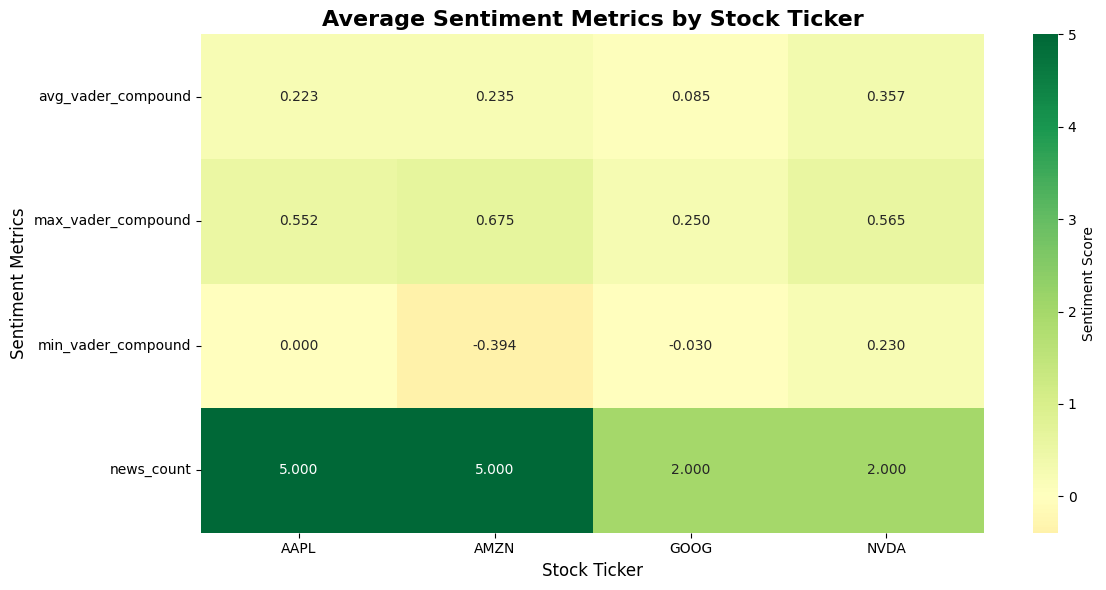

In [38]:
# Sentiment Heatmap by Stock
if not sentiment_aggregated.empty:
    # Create pivot table for sentiment metrics by stock
    sentiment_pivot = sentiment_aggregated.pivot_table(
        index='stock', 
        values=['avg_vader_compound', 'max_vader_compound', 'min_vader_compound', 'news_count'],
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(sentiment_pivot.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Sentiment Score'})
    plt.title('Average Sentiment Metrics by Stock Ticker', fontsize=16, fontweight='bold')
    plt.xlabel('Stock Ticker', fontsize=12)
    plt.ylabel('Sentiment Metrics', fontsize=12)
    plt.tight_layout()
    plt.show()


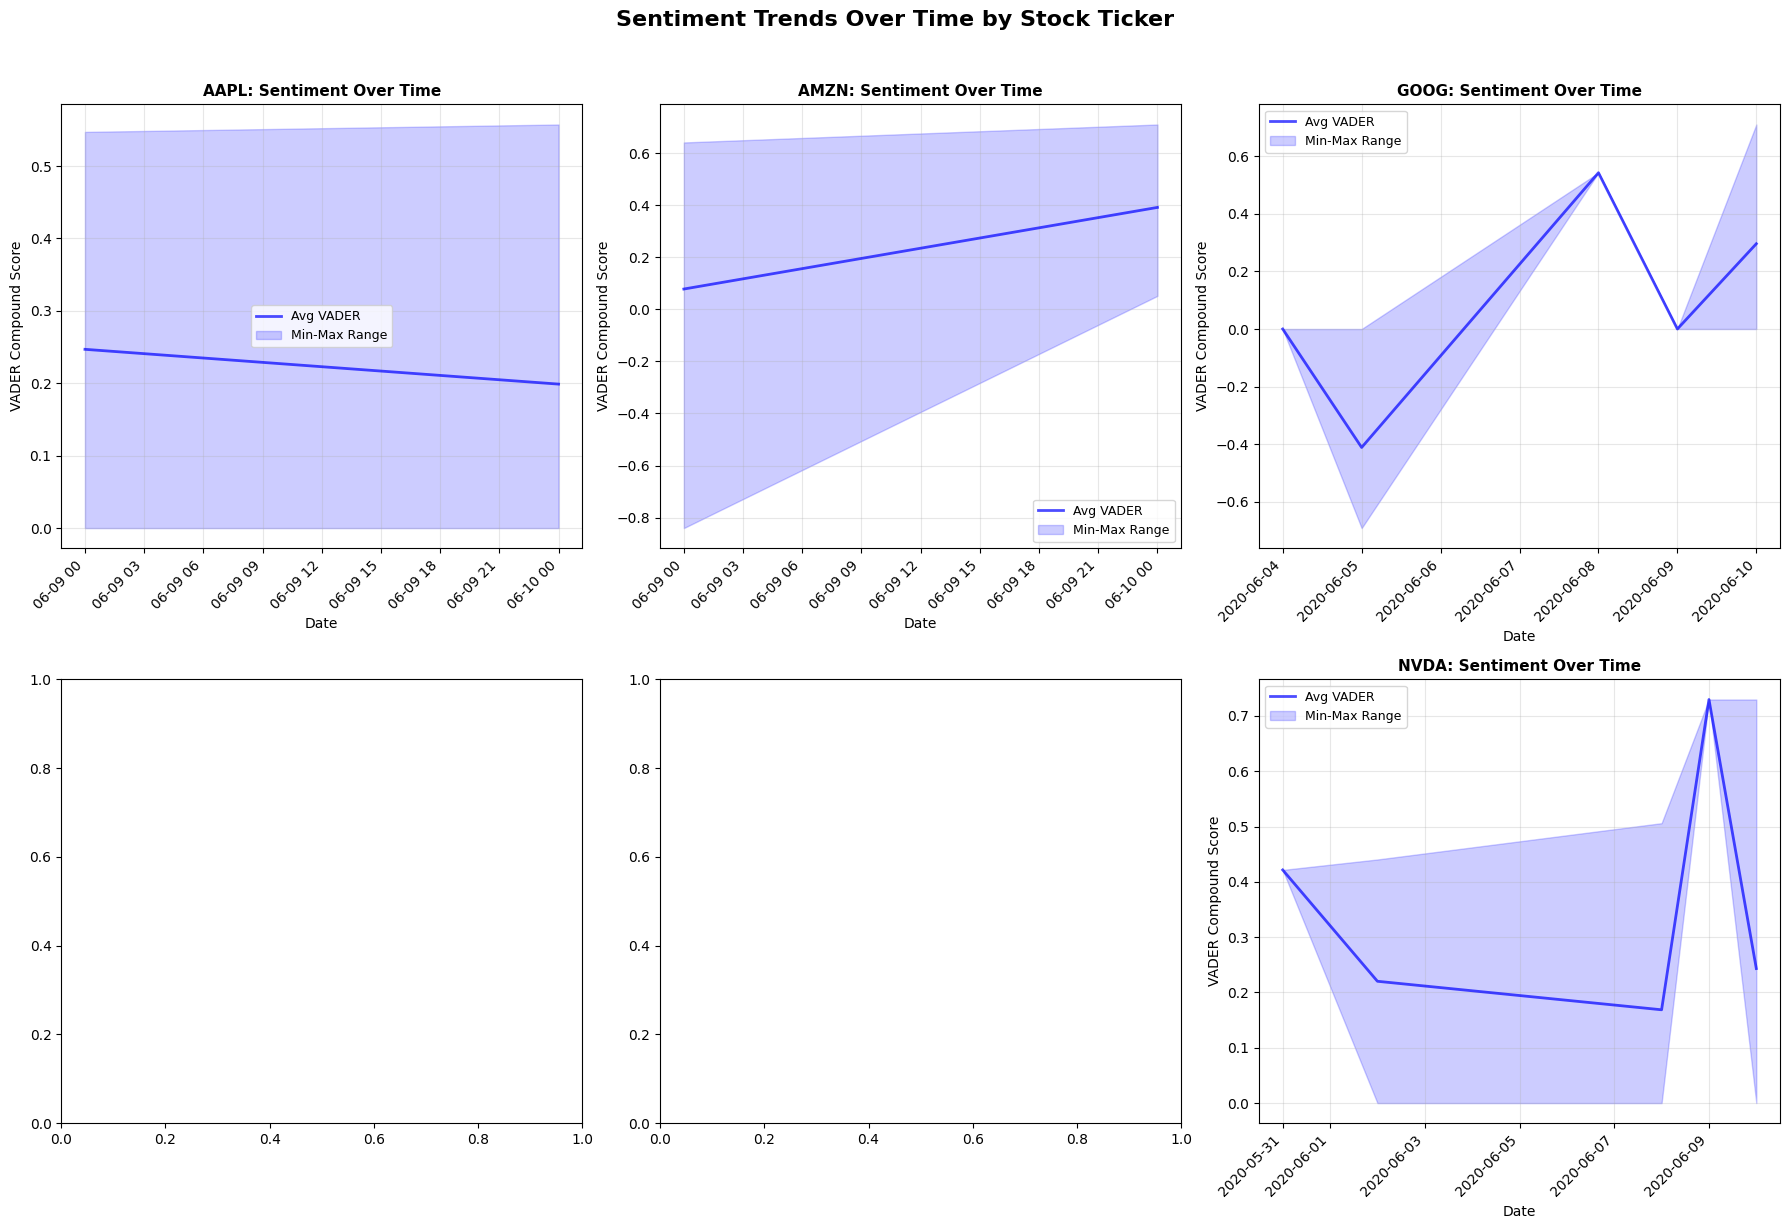

In [39]:
# Time Series: Sentiment Over Time by Stock
if not sentiment_aggregated.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    stock_tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
    
    for idx, ticker in enumerate(stock_tickers):
        ticker_data = sentiment_aggregated[sentiment_aggregated['stock'] == ticker].sort_values('aligned_date')
        
        if len(ticker_data) > 0:
            ax = axes[idx]
            
            # Plot average sentiment over time
            ax.plot(ticker_data['aligned_date'], ticker_data['avg_vader_compound'], 
                   'b-', alpha=0.7, label='Avg VADER', linewidth=2)
            ax.fill_between(ticker_data['aligned_date'], 
                           ticker_data['min_vader_compound'], 
                           ticker_data['max_vader_compound'],
                           alpha=0.2, color='blue', label='Min-Max Range')
            
            ax.set_title(f'{ticker}: Sentiment Over Time', fontsize=11, fontweight='bold')
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('VADER Compound Score', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Sentiment Trends Over Time by Stock Ticker', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


## 💾 Save Results


In [40]:
# Save aggregated sentiment results
output_dir = str(project_root / 'data' / 'processed')
os.makedirs(output_dir, exist_ok=True)

# Save aggregated sentiment data
if not sentiment_aggregated.empty:
    sentiment_aggregated.to_csv(
        os.path.join(output_dir, 'task3_aggregated_sentiment.csv'), 
        index=False
    )
    print(f"\n💾 Saved aggregated sentiment data: {len(sentiment_aggregated):,} records")
    print(f"   Location: {os.path.join(output_dir, 'task3_aggregated_sentiment.csv')}")

print("\n✅ Task 3 Sentiment Aggregation Analysis Complete!")



💾 Saved aggregated sentiment data: 14 records
   Location: d:\Senait Doc\KAIM 8 Doc\Nova_Financial_Analysis\data\processed\task3_aggregated_sentiment.csv

✅ Task 3 Sentiment Aggregation Analysis Complete!
